In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

'''
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass
'''    


'\nif torch.cuda.is_available():\n    torch.set_default_tensor_type(torch.cuda.FloatTensor)\n    print("using cuda:", torch.cuda.get_device_name(0))\n    pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n\nfrom multiprocessing import set_start_method\ntry:\n    set_start_method(\'spawn\')\nexcept RuntimeError:\n    pass\n'

In [3]:
baseline = 2.5

In [4]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = float(self.y[idx] > baseline)
        #print("self.y[idx]", self.y[idx], 'label', label)

        target = torch.FloatTensor([label])
        
        return sample, label, target


In [5]:
real_data = pandas.read_csv('dataset/qm9.csv')
real_data = real_data[0:1000]


max_mu = max(real_data['mu'])
min_mu = min(real_data['mu'])
number_of_data = len(real_data)

number1 = len(real_data[real_data['mu'] > baseline])
number2 = len(real_data[real_data['mu'] <= baseline])
print(' > 3)', number1, ' <= 3)', number2)
print("number_of_data", number_of_data, "max_mu", max_mu, "min_mu", min_mu)
#real_data.head(5)


print(real_data['mu'])

 > 3) 405  <= 3) 595
number_of_data 1000 max_mu 14.8809 min_mu 0.0
0      0.0000
1      1.6256
2      1.8511
3      0.0000
4      2.8937
        ...  
995    1.7250
996    1.1867
997    3.7673
998    2.4520
999    4.0475
Name: mu, Length: 1000, dtype: float64


In [6]:
data = pandas.read_csv('dataset/qm9.csv')
data = data[0:10000]
#pandas.read_csv('dataset/GDB13_Subset-ABCDEFGH.smi', header=None, names=["smiles"])
data.head(5)


,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
0,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246


,smiles,Molecule
0,C,

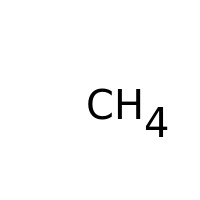

In [7]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data = data[0:number_of_data]
data[["smiles","Molecule"]].head(1)


In [8]:
data['smiles'].iloc[10]

'CC=O'

,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298,Molecule
0,C,0.0,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.47893,-40.476062,-40.475117,-40.498597,

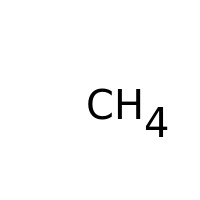

In [9]:
real_data1 = real_data
PandasTools.AddMoleculeColumnToFrame(real_data1,'smiles','Molecule')
real_data1[["smiles","Molecule"]].head(1)
real_data['Molecule'] = real_data1[['Molecule']]
real_data.head(1)

In [10]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(real_data.Molecule.values, )

In [11]:
smivec_data = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec_data.fit(data.Molecule.values, )

In [12]:
# functions to generate random data

def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    #random_data = np.round(np.random.randint(int(min_mu), int(max_mu * 100), (1, size))/100,4)
    random_data = np.random.randint(0, baseline * 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    #random_data = torch.round((torch.randn(size) * 10000) / 100)
    #round(random.uniform(min_alpha, max_alpha),2)
    return random_data.view(-1)

def generate_random_label(size):
    random_data = np.random.randint(0, 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    #random_data = torch.round((torch.randn(size) * 10000) / 100)
    #round(random.uniform(min_alpha, max_alpha),2)
    return random_data.view(-1)


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

print(generate_random_value(5))
print(generate_random_label(5))

tensor([0., 1., 0., 2., 1.])
tensor([0., 1., 0., 1., 0.])


In [13]:
y = real_data.mu.values.reshape((-1,1))
X = real_data.Molecule.values

#Normalizing output using standard scaling
scaler = StandardScaler()
X_train = X
y_train = real_data['mu']
#scaler.fit_transform(y)

print('len(X_train)',len(X_train),'y_train[1]', y_train[1])

len(X_train) 1000 y_train[1] 1.6256


In [14]:
data_y = generate_random_value(number_of_data).reshape((-1,1))
data_X = data.Molecule.values
scaler = StandardScaler()
#data_y = scaler.fit_transform(data_y)
data_dataset = SMILESMolDataset(data_X, data_y, smivec_data)
print('data_dataset[10]', data_dataset[10], 'data_y', data_y[10] )


data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       

In [15]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[10]
print('train_dataset[10]', train_dataset[10], 'len(train_dataset[10][0])', len(train_dataset[10][0]) )

train_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      

In [16]:
# return a random SMILES from the GDB13_Subset
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    #random_data = data_dataset[10]
    return random_data

generate_random_seed(2)[0][1]

0.0

In [17]:
epochs = 5000
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
out_size = 1        # This is just a single task, so this will be one
batch_size = 1   # The mini_batch size during training
#batch_size = 128   # The mini_batch size during training
#batch_size = 1   # The mini_batch size during training
G_input_size = 100 # The Generator input data size
#learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.001  # The Generator initial learning rate for the optimizer
learning_rate_D = 0.0001  # The Discriminator initial learning rate for the optimizer 
learning_rate_G = 0.0001  # The Generator initial learning rate for the optimizer

In [18]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer
        #print('LSTM input_size', number_tokens)
         
        
        #self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        #self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        #self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        #self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #self.dropout = nn.Dropout(dropout_rate)       
        
        # define neural network layers
        self.model = nn.Sequential(
            View(483),
            nn.Linear(483, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_D)
        #self.lr_scheduler = ReduceLROnPlateau(self.optimiser, mode='min', factor=0.5, patience=50, 
        #          verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        # combine seed and label
        
        #print("input_tensor.shape", input_tensor.shape, "label_tensor.shape", label_tensor.shape)
        x = torch.cat((input_tensor, label_tensor), -1)
        
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        #out = self.dropout(h_n) #Dropout
        #out = self.fc1(out) # Pass into the hidden layer
        #out = self.activation(out) # Use ReLU on hidden activation
        #out = self.dropout(out) # dropout
        #out = self.fc_out(out) # Use a linear layer for the output
        #return out
        
        return self.model(x)
        
        
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network Discriminator
        outputs = self.forward(inputs, label_tensor)
        
        
        #print('outputs', outputs)
        #print('targets', targets)
        # calculate loss
        #outputs = outputs.view(-1)
        #targets = targets.view(-1)
        #print('outputs.shape', outputs.shape, 'targets.shape',targets.shape)
        
        if (outputs.shape != targets.shape):
            print("Generator loss function issue: outputs.shape != targets.shape", outputs.shape, targets.shape)

        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [19]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )



In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label, target in data_loader:
    # real
    target = target.view(1).to(device)
    #print('0.before change label.shape', label.shape, 'smiles', smiles.shape, 'target.shape', target.shape)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
    D.train(smiles.to(device).float(), label, target)
    
    # fake
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    #print('fake_label', fake_label)
    target = torch.FloatTensor(fake_label).to(device)
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    fake_label = torch.FloatTensor(fake_label).to(device)
#    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    D.train(fake_input, fake_label, target)

    pass

counter =  1000
counter =  2000
CPU times: user 8.51 s, sys: 1.18 s, total: 9.69 s
Wall time: 10 s


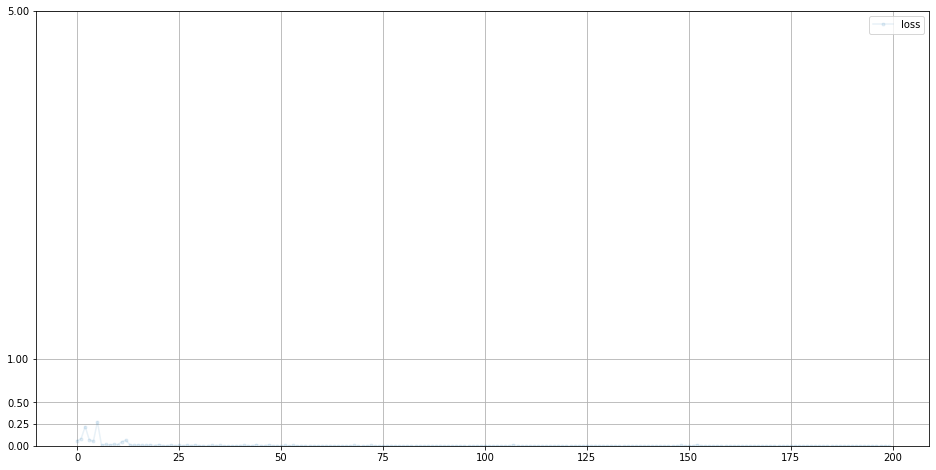

In [22]:
D.plot_progress()

In [23]:

i = 0
for smiles,label,target in data_loader:
    # real
    #target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    result = D.forward(smiles.to(device).float(), label)
    print('label', label)
    print('result',result)
    
    
    i += 1
    if (i >= 1):
        break
    pass



label tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
result tensor([0.0101], device='cuda:0', grad_fn=<SigmoidBackward>)


In [24]:
# fake
fake_input = []
fake_label = []
for item in generate_random_seed(batch_size):
    fake_input.append(item[0])
    fake_label.append(item[1])
    
#print('fake_label', fake_label)
target = torch.FloatTensor(fake_label).view(1,len(fake_label),1).to(device)
fake_input = torch.FloatTensor(fake_input).to(device)
    
fake_label = torch.FloatTensor(fake_label).to(device)
#    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
result = D.forward(fake_input, fake_label)
#print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
print('fake_label', fake_label)
print('result', result) 


fake_label tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]], device='cuda:0')
result tensor([0.9976], device='cuda:0', grad_fn=<SigmoidBackward>)


In [25]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        # initialise parent pytorch class
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(G_input_size * 2, 200),
            nn.LeakyReLU(0.02),
            #nn.LayerNorm(200),
            nn.Linear(200, number_of_data)
            #nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_G)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('Generator seed_tensor.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        outputs = self.model(inputs)
        #print('outputs', outputs)
        return torch.argmax(F.softmax(outputs, dim=0))


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)

        g_smiles, g_label, _ = data_dataset[g_output]
        
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        g_label = torch.FloatTensor([g_label]).to(device)
        g_label = g_label.unsqueeze(1).repeat(1, g_input.shape[1], 1)
        
        # pass onto Discriminator
        d_output = D.forward(g_input, g_label)
        
        #print('d_output.shape', d_output.shape, 'targets.shape', targets.shape)
        if (d_output.shape != targets.shape):
            print("Generator loss function issue: d_output.shape != targets.shape", d_output.shape, targets.shape)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    

    def get_smiles(self, label):
        label_tensor = torch.zeros((G_input_size))
        for i in range(G_input_size):
            label_tensor[i] = label
    
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(label_tensor).to(device)
        idx = G.forward(fake_input, fake_label).detach().cpu().numpy()
        #print('idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
        #idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
    
        #data['smiles'].iloc[idx]
        return real_data['smiles'].iloc[idx]

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [26]:
# check the generator output is of the right type and shape

G = Generator(1)
G.to(device)

#fake = generate_random_seed()
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
idx = G.forward(fake_input, fake_label)
print('idx', idx)
data_dataset[idx]




idx tensor(98, device='cuda:0')


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 

In [27]:
G.get_smiles(1.0)

'C1CCCC1'

In [ ]:
%%time

# train Discriminator and Generator
D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)


for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        #########################################################                   
        # train discriminator on true
        #########################################################                   
        target = torch.FloatTensor(torch.ones(smiles.shape[0])).to(device)
        #print('0.before change label.shape', label.shape, 'smiles', smiles.shape, 'target.shape', target.shape)
        label = label.float().to(device)
        label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
        #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
        D.train(smiles.to(device).float(), label, target)
        
        #########################################################                   
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        #########################################################      
        # fake
        fake_input = []
        fake_label = []
        for item in generate_random_seed(batch_size):
            fake_input.append(item[0])
            fake_label.append(item[1])
    
        #print('fake_label', fake_label)
        target = torch.FloatTensor(torch.zeros(len(fake_label))).to(device)
        fake_input = torch.FloatTensor(fake_input).to(device)
        fake_label = torch.FloatTensor(fake_label).to(device)
        #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
        fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
        #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
        target = torch.FloatTensor([0.0]).to(device)
        D.train(fake_input, fake_label, target)
        
        
        #########################################################                   
        # train generator
        #########################################################                   
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(torch.zeros(G_input_size)).to(device)
        #print('fake_label', fake_label)
        #print('fake_label.shape', fake_label.shape)
        #fake_label = fake_label.view(1,G_input_size,1)
        target = torch.FloatTensor([0.0]).to(device)
        G.train(D, fake_input, fake_label, target)
    pass
    
pass


epoch =  1
counter =  1000
counter =  2000
epoch =  2
counter =  3000
counter =  4000
epoch =  3
counter =  5000
counter =  6000
epoch =  4
counter =  7000
counter =  8000
epoch =  5
counter =  9000
counter =  10000
epoch =  6
counter =  11000
counter =  12000
epoch =  7
counter =  13000
counter =  14000
epoch =  8
counter =  15000
counter =  16000
epoch =  9
counter =  17000
counter =  18000
epoch =  10
counter =  19000
counter =  20000
epoch =  11
counter =  21000
counter =  22000
epoch =  12
counter =  23000
counter =  24000
epoch =  13
counter =  25000
counter =  26000
epoch =  14
counter =  27000
counter =  28000
epoch =  15
counter =  29000
counter =  30000
epoch =  16
counter =  31000
counter =  32000
epoch =  17
counter =  33000
counter =  34000
epoch =  18
counter =  35000
counter =  36000
epoch =  19
counter =  37000
counter =  38000
epoch =  20
counter =  39000
counter =  40000
epoch =  21
counter =  41000
counter =  42000
epoch =  22
counter =  43000
counter =  44000
epoch 

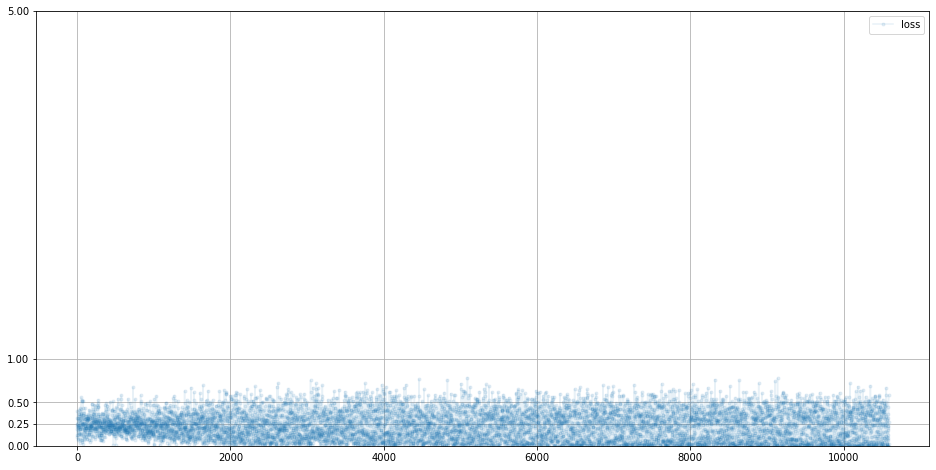

In [29]:
D.plot_progress()

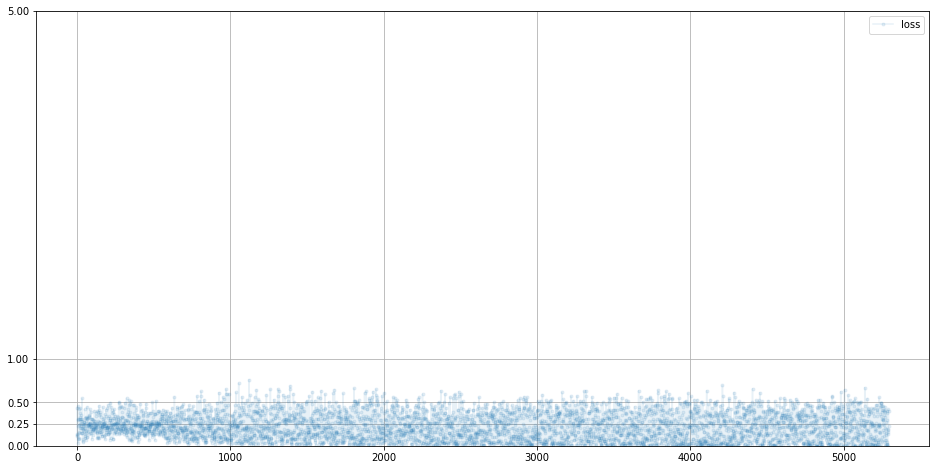

In [30]:
G.plot_progress()

In [31]:
i = 0
for smiles,label,target in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    #print(label)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass



tensor([0.7279], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5886], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5892], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6612], device='cuda:0', grad_fn=<SigmoidBackward>)


In [32]:
for i in range(4):
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    print(D.forward(fake_input, fake_label))
    pass


tensor([0.0232], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6305], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5841], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5170], device='cuda:0', grad_fn=<SigmoidBackward>)


In [33]:
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
result = G.forward(fake_input, fake_label).detach()
idx = result.cpu().numpy()
print('result', result, 'idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
        
#idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
print(data['smiles'].iloc[idx])

result tensor(428, device='cuda:0') idx 428 fake_input torch.Size([100]) fake_label.shape torch.Size([100]) result.shape torch.Size([])
OC1CNC1=O


In [42]:
accuracy = []
number_of_verify = 1000
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = real_data[real_data['smiles'] == test_smiles ]
    #print('real data', real.iat[0,0],real.iat[0,1], real.iat[0,1] > baseline)
    accuracy.append(real.iat[0,1] > baseline)
np.mean(accuracy)
    


0.615

In [44]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN17G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN17D' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(D, open(D_filename, 'wb'))


#G_model = pickle.load(open(G_filename, 'rb'))

save model to file: pre_train_model/GAN17GG202104131916.sav
save model to file: pre_train_model/GAN17GG202104131916.sav
